In [7]:
import xarray as xr
import time

In [27]:
# aifs_nh = xr.open_dataset('AIFS_TP_FFX24_NH.nc')
# ifs_nh = xr.open_dataset('IFS_TP_FFX24_NH.nc')
# era_nh = xr.open_dataset('ERA_NH.nc')

# aifs_tp = xr.open_dataset('AIFS_TP_FFX24_TP.nc')
# ifs_tp = xr.open_dataset('IFS_TP_FFX24_TP.nc')
# era_tp = xr.open_dataset('ERA_TP.nc')

# aifs_sh = xr.open_dataset('AIFS_TP_FFX24_SH.nc')
# ifs_sh = xr.open_dataset('IFS_TP_FFX24_SH.nc')
# era_sh = xr.open_dataset('ERA_SH.nc')

In [9]:
def align_era_to_target_grid(target_dataset, era):
    # target grid (AIFS/IFS without the member dim)
    target = target_dataset.isel(number=0).drop_vars([v for v in target_dataset.coords if v not in ("time","latitude","longitude")], errors="ignore")

    # 1) Convert ERA lon labels to [-180, 180) AND reorder data accordingly
    era = era.assign_coords(longitude=((era.longitude + 180) % 360) - 180).sortby("longitude")

    # 2) Make latitude orientation match the target
    era = era.sortby("latitude", ascending=bool(target.latitude[0] < target.latitude[-1]))

    # 3) Put ERA *values* onto the exact target grid
    #    - If grids are identical: reindex (no interpolation)
    era_on_target = era.reindex_like(target, method=None)

    #   - If there are tiny differences in points/resolution: interpolate instead
    # era_on_target = era.interp_like(target)

    # Sanity checks
    # for d in ("time", "latitude", "longitude"):
    #     assert era_on_target[d].equals(target[d]), f"{d} still differs"
    
    return era_on_target    


In [12]:
start = time.time()
# era_nh_aligned = align_era_to_target_grid(aifs_nh, era_nh)
# era_tp_aligned = align_era_to_target_grid(aifs_tp, era_tp)
era_sh_aligned = align_era_to_target_grid(aifs_sh, era_sh)
print(time.time() - start)

0.01862502098083496


In [10]:
era_s2

NameError: name 'era_s2' is not defined

In [35]:
aifs_sh.t2m

<xarray.DataArray 't2m' (time: 90, number: 50, latitude: 267, longitude: 1440)> Size: 7GB
[1730160000 values with dtype=float32]
Coordinates:
  * time               (time) datetime64[ns] 720B 2025-07-02T06:00:00 ... 202...
  * number             (number) int64 400B 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * latitude           (latitude) float64 2kB -23.5 -23.75 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    valid_time         (time) datetime64[ns] 720B ...
Attributes: (12/31)
    GRIB_paramId:                             167
    GRIB_dataType:                            pf
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         51
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

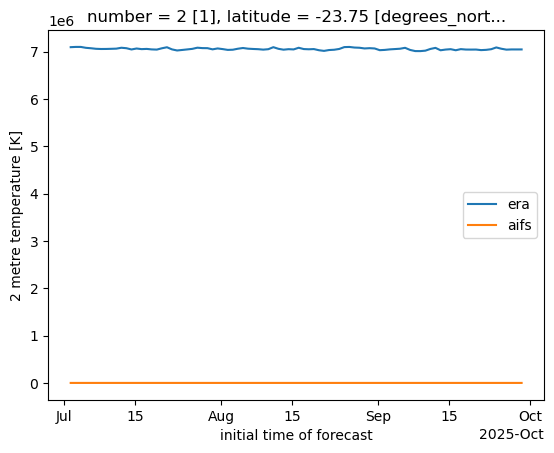

In [29]:
import matplotlib.pyplot as plt
era_sh_aligned.t2m_daily_06UTC.isel(latitude=1, longitude=1).plot(label='era')
aifs_sh.t2m.isel(latitude=1, longitude=1, number=1).plot(label='aifs')
plt.legend()

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def crps_fair(forecast: xr.DataArray, obs: xr.DataArray, member_dim="member"):
    """
    forecast: DataArray with a member dimension (…, member)
    obs     : DataArray broadcastable to forecast without the member dim (…)
    returns : CRPS_fair with the member dim removed
    """
    M = forecast.sizes[member_dim]
    # term1 = mean |X - y|
    term1 = (np.abs(forecast - obs)).mean(dim=member_dim)

    # term2 = 0.5 * mean_{i≠j} |X - X'|
    def _pairwise_mean_offdiag(a):
        # a: (..., M)
        # pairwise |a_i - a_j|
        diff = np.abs(a[..., None] - a[..., None, :])  # (..., M, M)
        # sum over i,j; diagonal is zero so no need to subtract explicitly
        s = diff.sum(axis=(-2, -1))
        denom = M * (M - 1)
        # handle M=1 safely
        return np.where(denom > 0, 0.5 * s / denom, 0.0)

    term2 = xr.apply_ufunc(
        _pairwise_mean_offdiag, forecast,
        input_core_dims=[[member_dim]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[forecast.dtype],
        dask_gufunc_kwargs = {'allow_rechunk':True}
    )

    return term1 - term2

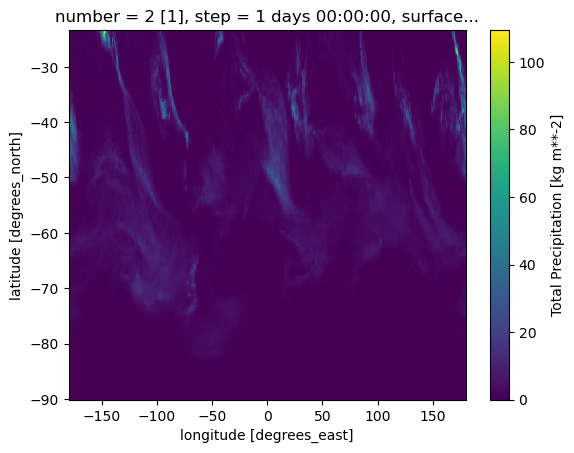

In [6]:
# aifs_nh.tp.isel(time=1, number=1).plot()
# aifs_tp.tp.isel(time=1, number=1).plot()
aifs_sh.tp.isel(time=1, number=1).plot()

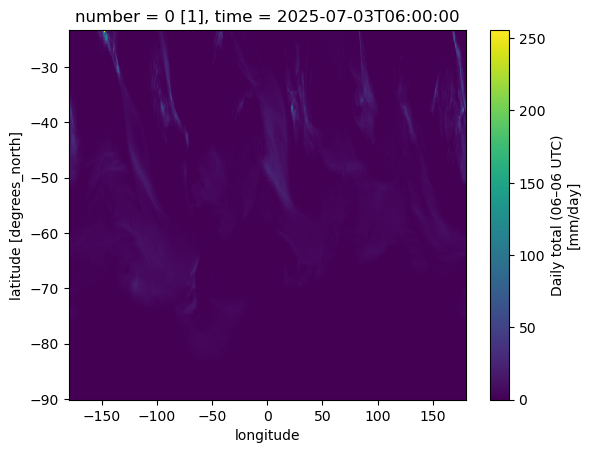

In [7]:
# era_nh_aligned.tp_daily_06UTC.isel(time=1).plot()
# era_tp_aligned.tp_daily_06UTC.isel(time=1).plot()
era_sh_aligned.tp_daily_06UTC.isel(time=1).plot()

In [8]:
era_nh_aligned_TP = era_nh_aligned.tp_daily_06UTC
aifs_nh_TP = aifs_nh.tp
ifs_nh_TP = ifs_nh.tp*1000
print("NH datasets prepared.")

era_tp_aligned_TP = era_tp_aligned.tp_daily_06UTC
aifs_tp_TP = aifs_tp.tp
ifs_tp_TP = ifs_tp.tp*1000
print("TR datasets prepared.")

era_sh_aligned_TP = era_sh_aligned.tp_daily_06UTC
aifs_sh_TP = aifs_sh.tp
ifs_sh_TP = ifs_sh.tp*1000
print("SH datasets prepared.")

NH datasets prepared.
TR datasets prepared.
SH datasets prepared.


In [9]:
era_nh_aligned_TP.to_netcdf("ERA_NH_TP_aligned.nc")
era_sh_aligned_TP.to_netcdf("ERA_SH_TP_aligned.nc")
era_tp_aligned_TP.to_netcdf("ERA_TP_TP_aligned.nc")

In [ ]:
aifs_tp_TP.to_netcdf("AIFS_TP_TP.nc")
ifs_tp_TP.to_netcdf("IFS_TP_TP.nc")

aifs_nh_TP.to_netcdf("AIFS_NH_TP.nc")
ifs_nh_TP.to_netcdf("IFS_NH_TP.nc")

aifs_sh_TP.to_netcdf("AIFS_SH_TP.nc")
ifs_sh_TP.to_netcdf("IFS_SH_TP.nc")

In [20]:
# NH CRPS
start = time.time()
crps_aifs_nh = crps_fair(forecast=aifs_nh_TP,
              obs=era_nh_aligned_TP,
              member_dim='number')
elapsed = time.time() - start
print(elapsed)

start = time.time()
crps_ifs_nh = crps_fair(forecast=ifs_nh_TP,
                obs=era_nh_aligned_TP,
                member_dim='number')
elapsed = time.time() - start
print(elapsed)

524.3546402454376


: 

In [ ]:
crps_aifs_nh

In [ ]:
# TP CRPS
start = time.time()
crps_aifs_tp = crps_fair(forecast=aifs_tp_TP,
              obs=era_tp_aligned_TP,
              member_dim='number')
elapsed = time.time() - start
print(elapsed)

start = time.time()
crps_ifs_tp = crps_fair(forecast=ifs_tp_TP,
                obs=era_tp_aligned_TP,
                member_dim='number')
elapsed = time.time() - start
print(elapsed)

In [ ]:
# SH CRPS
start = time.time()
crps_aifs_sh = crps_fair(forecast=aifs_sh_TP,
              obs=era_sh_aligned_TP,
              member_dim='number')
elapsed = time.time() - start
print(elapsed)

start = time.time()
crps_ifs_sh = crps_fair(forecast=ifs_sh_TP,
                obs=era_sh_aligned_TP,
                member_dim='number')
elapsed = time.time() - start
print(elapsed)

In [26]:
era.mean(), aifs.mean(), ifs.mean()

(<xarray.DataArray 'tp_daily_06UTC' ()> Size: 4B
 array(2.163503, dtype=float32)
 Coordinates:
     number   int64 8B ...,
 <xarray.DataArray 'tp' ()> Size: 4B
 array(2.0021014, dtype=float32)
 Coordinates:
     step     timedelta64[ns] 8B ...
     surface  float64 8B ...,
 <xarray.DataArray 'tp' ()> Size: 4B
 array(2.2740173, dtype=float32)
 Coordinates:
     step     timedelta64[ns] 8B ...
     surface  float64 8B ...)

In [28]:
start = time.time()
crps_ifs = crps_fair(forecast=ifs, 
                     obs=era,
                     member_dim='number')
elapsed = time.time() - start

print(elapsed)

498.64117550849915


In [29]:
crps_aifs.mean()

<xarray.DataArray ()> Size: 4B
array(0.65664226, dtype=float32)
Coordinates:
    step     timedelta64[ns] 8B 1 days
    surface  float64 8B 0.0

In [30]:
crps_ifs.mean()

<xarray.DataArray ()> Size: 4B
array(0.67998123, dtype=float32)
Coordinates:
    step     timedelta64[ns] 8B 1 days
    surface  float64 8B 0.0